In [3]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Reshape, Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

D:\environment\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
(x_real, y_real), (x_test, y_test) = mnist.load_data()
x_real = np.expand_dims(x_real, axis = -1)
print(x_real.shape)
num_real_sample, img_W, img_H, channel = x_real.shape
noisy_dim = 100

(60000, 28, 28, 1)


In [44]:
def build_generator():
    model = Sequential()
    model.add(Dense(128, activation='sigmoid', input_shape = (noisy_dim,), kernel_initializer=tf.contrib.layers.xavier_initializer()))
    model.add(Dense(img_W * img_H, activation='tanh',kernel_initializer=tf.contrib.layers.xavier_initializer()))
    model.add(Reshape([img_W, img_H, 1]))
    
    noisy = Input(shape=[noisy_dim,])
    img = model(noisy)
    G = Model(inputs = noisy, outputs = img)
    return G

In [45]:
generator = build_generator()
print("generator 的输入shape为：", generator.inputs)
print("generator 的输出shape为：", generator.outputs)
print("generator 的layers为：", generator.layers)
print(generator.summary())

generator 的输入shape为： [<tf.Tensor 'input_25:0' shape=(?, 100) dtype=float32>]
generator 的输出shape为： [<tf.Tensor 'sequential_19/reshape_10/Reshape:0' shape=(?, 28, 28, 1) dtype=float32>]
generator 的layers为： [<keras.engine.input_layer.InputLayer object at 0x00000155C3D59EF0>, <keras.engine.sequential.Sequential object at 0x00000155C3DC55C0>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 100)               0         
_________________________________________________________________
sequential_19 (Sequential)   (None, 28, 28, 1)         114064    
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape = [img_W, img_H, 1]))
    model.add(Dense(256, activation = 'relu',kernel_initializer=tf.contrib.layers.xavier_initializer()))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu',kernel_initializer=tf.contrib.layers.xavier_initializer()))
    model.add(Dense(1, activation = 'sigmoid',kernel_initializer=tf.contrib.layers.xavier_initializer()))
    
    img = Input(shape = [img_W, img_H, 1])
    validity = model(img)
    
    D = Model(inputs = img, outputs = validity)
    D.compile(loss='binary_crossentropy',
             optimizer=Adam(0.001),
             metrics=['accuracy'])
    return D

In [47]:
discriminator = build_discriminator()
print(discriminator.summary())
print(discriminator.inputs)
print(discriminator.outputs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_20 (Sequential)   (None, 1)                 217473    
Total params: 217,473
Trainable params: 217,473
Non-trainable params: 0
_________________________________________________________________
None
[<tf.Tensor 'input_26:0' shape=(?, 28, 28, 1) dtype=float32>]
[<tf.Tensor 'sequential_20/dense_50/Sigmoid:0' shape=(?, 1) dtype=float32>]


In [48]:
def GAN():
    D = build_discriminator()
    G = build_generator()
    
    z = Input(shape=[noisy_dim,])
    g_imgs = G(z)
    D.trainable = False
    D_fake = D(g_imgs)
    gan_model = Model(inputs = z, outputs = D_fake)
    gan_model.compile(loss='binary_crossentropy',
                     optimizer = Adam(0.001),
                     metrics = ['accuracy'])
    
    gan_model.summary()
    return gan_model, G, D

In [49]:
def G_loss(y_pred, y_true):
    return -tf.reduce_mean(tf.log(y_true))

In [50]:
def train(D, G, gan_model, noisy_dim = 100,epochs = 1000, batch_size = 64, verbose = True):
    (x_real, y_real), (x_test, y_test) = mnist.load_data()
    x_real = x_real / 127.5 - 1
    x_real = np.expand_dims(x_real, axis = 3)
    #fake label and img label
    ones = np.ones([batch_size, 1])
    zeros = np.zeros([batch_size, 1])
    plt.figure()
    for epoch in range(epochs):
        
        #batch data
#         idx = np.random.choice(num_real_sample, size=batch_size, replace = False)
        idx = np.random.randint(0, num_real_sample, size = batch_size)
        imgs_batch = x_real[idx]
        
        noisy_batch = np.random.normal(0., 1., size = [batch_size, noisy_dim])
        g_imgs_batch = G.predict_on_batch(noisy_batch)
        #train discriminator
        d_loss_real = D.train_on_batch(imgs_batch, ones)
        d_loss_fake = D.train_on_batch(g_imgs_batch, zeros)
        d_loss = np.add(d_loss_real, d_loss_fake)
#         print(d_loss_real, d_loss_fake)
        
        #train generator
        noisy_batch = np.random.normal(0., 1., size = [batch_size, noisy_dim]) 
        g_loss = gan_model.train_on_batch(noisy_batch, ones)
      
        if verbose == True and epoch % 1000 == 0:
            print("Epoch: %d, G_loss: %f, D_loss: %f" %(epoch, g_loss[0], d_loss[0]))
            g_imgs = G.predict(noisy_batch)
            # np.random.seed(100)
            noisy_batch = np.random.uniform(-1., 1., size = [16, noisy_dim])
            imgs = G.predict(noisy_batch)
            
            for idx in range(noisy_batch.shape[0]):
                plt.subplot(4,4,idx+1)
                plt.imshow(imgs[idx,:,:,0], cmap='gray')
                plt.axis('off')
            plt.show()

D:\environment\Anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, G_loss: 1.511925, D_loss: 1.196611


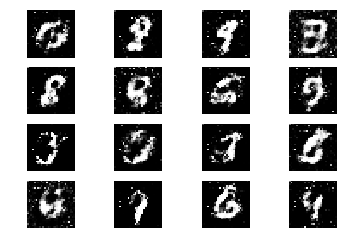

Epoch: 1000, G_loss: 1.351944, D_loss: 0.935201


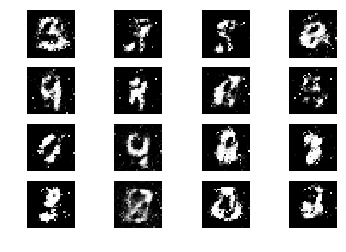

Epoch: 2000, G_loss: 1.115693, D_loss: 0.972667


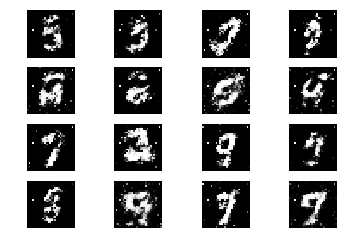

Epoch: 3000, G_loss: 1.157613, D_loss: 1.110558


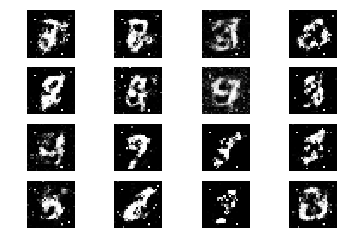

Epoch: 4000, G_loss: 1.226335, D_loss: 1.057876


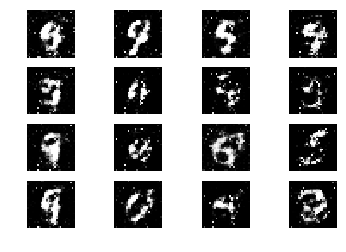

Epoch: 5000, G_loss: 1.169981, D_loss: 1.154898


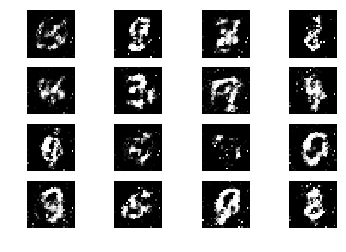

Epoch: 6000, G_loss: 1.098366, D_loss: 1.078205


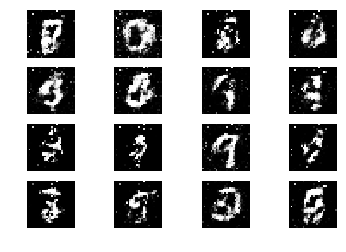

Epoch: 7000, G_loss: 1.026677, D_loss: 1.033652


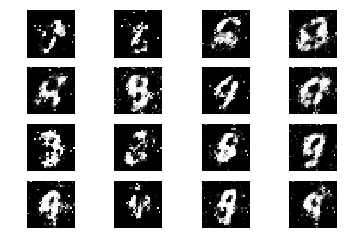

Epoch: 8000, G_loss: 1.344731, D_loss: 1.091926


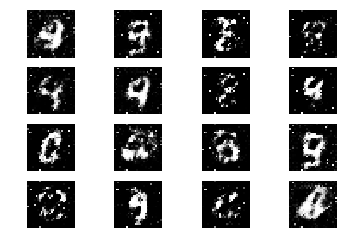

Epoch: 9000, G_loss: 1.332849, D_loss: 1.040002


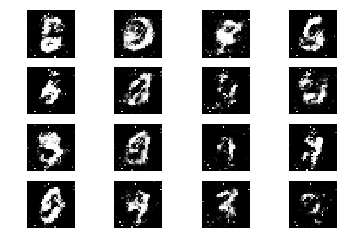

In [54]:
# gan_model, G, D = GAN()
train(D, G, gan_model, noisy_dim ,epochs = 10000)

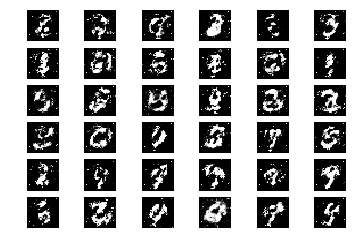

In [56]:
noisy_batch = np.random.normal(0., 2, size = [36, noisy_dim])
imgs = G.predict(noisy_batch)

for idx in range(noisy_batch.shape[0]):
    plt.subplot(6,6,idx+1)
    plt.imshow(imgs[idx,:,:,0], cmap='gray')
    plt.axis('off')
plt.show()